In [71]:
# !pip install boto3
# !pip install sagemaker
# !pip install xlrd
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
import boto3
from sagemaker.image_uris import retrieve
import sagemaker
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc


In [16]:
# Get the data from github
github_url = 'https://github.com/mjochen/CloudAI/raw/master/Exercises/files/titanic3.xls'
response = requests.get(github_url)

# Check if the request was successful
if response.status_code == 200:
    excel_data = io.BytesIO(response.content)
    df = pd.read_excel(excel_data, engine='xlrd')
else:
    print("Failed to retrieve the Excel file from GitHub.")

### Clean the data
Unclear names are changed.  
Sex is converted into binary values.  
The parents_children and siblings_spouses columns are summarized in the binary alone column (passengers without siblings, spouses, parents, or children are considered to be alone).  
Columns with too many NaN values or meaningless info are dropped.  
The order of the columns is changed for clarity.
It should be noted that class is a categorical column and both sex, survived, and alone are binary columns.

In [17]:
# change names
df = df.rename(columns={'pclass': 'class', 'sibsp': 'siblings_spouses', 'parch': 'parents_children', 'home.dest': 'home_destination'})
# create binary columns for sex and alone
df['sex'] = df['sex'].apply(lambda x: 0 if str(x) == 'male' else 1)
df['alone'] = df.apply(lambda row: 1 if row['parents_children'] == 0 and row['siblings_spouses'] == 0 else 0, axis=1)
# fill null values for age and fare
df['age'].fillna(value=df['age'].mean(), inplace=True)
df['fare'].fillna(value=df['fare'].mean(), inplace=True)
# drop unused columns
df.drop(['cabin', 'boat', 'body', 'ticket', 'name', 'home_destination', 'embarked'], axis=1, inplace=True)
#change order of columns
new_order = ['survived', 'sex', 'age',  'alone', 'siblings_spouses', 'parents_children', 'fare', 'class']
df = df[new_order]

df.head(5)

,survived,sex,age,alone,siblings_spouses,parents_children,fare,class
0,1,1,29.0000,1,0,0,211.3375,1
1,1,0,0.9167,0,1,2,151.5500,1
2,0,1,2.0000,0,1,2,151.5500,1
3,0,0,30.0000,0,1,2,151.5500,1
4,0,1,25.0000,0,1,2,151.5500,1


## Building Models

#### Encode Categorical Data
Amazon Sagemaker requires the categorical data to be manually encoded. In this df we have three non-ordinal categorical data columns: class (3 values), sex (binary), and alone (binary). I believe that one-hot encoding is the way to go for these, so that will be done in the following cells.

In [18]:
df = pd.get_dummies(df, columns=['sex', 'alone', 'class'])

# Clean up the column names
df = df.rename(columns={'sex_0': 'sex_male', 'sex_1': 'sex_female', 'alone_0': 'alone_no', 'alone_1': 'alone_yes'})

df.head()

,survived,age,siblings_spouses,parents_children,fare,sex_male,sex_female,alone_no,alone_yes,class_1,class_2,class_3
0,1,29.0000,0,0,211.3375,False,True,False,True,True,False,False
1,1,0.9167,1,2,151.5500,True,False,True,False,True,False,False
2,0,2.0000,1,2,151.5500,False,True,True,False,True,False,False
3,0,30.0000,1,2,151.5500,True,False,True,False,True,False,False
4,0,25.0000,1,2,151.5500,False,True,True,False,True,False,False


#### Split the Data
Amazon Sagemaker requires us to manually split the data in a training set, validation set, and a test set. These sets need to then be converted to csv files. That will be done here.  

In [19]:
# TODO adjust stratify and test_size
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42)
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42)

#### Train the XGBoost model
The first step is to upload all data to AWS.

In [22]:
# I am using the bucket used in the tutorial as that one contains other required files
bucket='c93435a2086654l4895998t1w1132433008-sandboxbucket-11ivs9oeqsp7h'

prefix='titanic'

train_file='training_data/train_ea.csv'
test_file='training_data/test_ea.csv'
validate_file='training_data/validate_ea.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [23]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

Now we can actually train the model.

In [24]:
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

In [25]:
# TODO experiment with num_round and maybe binary:hinge for the objective (uncommon choice)
hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

In [26]:
#  Set up the model
# TODO see how to experiment with this
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [27]:
# Set up channels
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [28]:
# Actually train the model
xgb_model.fit(inputs=data_channels, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-10-26-11-01-35-167



2023-10-26 11:01:35 Starting - Starting the training job....
2023-10-26 11:02:02 Starting - Preparing the instances for training................
2023-10-26 11:03:29 Downloading - Downloading input data.....................................
2023-10-26 11:06:40 Training - Training image download completed. Training in progress..
2023-10-26 11:06:50 Uploading - Uploading generated training model.
2023-10-26 11:07:01 Completed - Training job completed


## Predict

Here we will be using our model to make predictions. We will perform a batch transform; we will be applying the model to all test data at once.

In [35]:
# The one-hot encoded columns now contain True and False, this needs to be converted back to 1 and 0
columns_to_convert = ['sex_male', 'sex_female', 'alone_no', 'alone_yes', 'class_1', 'class_2', 'class_3']
test[columns_to_convert] = test[columns_to_convert].applymap(lambda x: int(x))

# Test data is saved in a csv and uploaded to the bucket
batch_X = test.iloc[:,1:];
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)




,age,siblings_spouses,parents_children,fare,sex_male,sex_female,alone_no,alone_yes,class_1,class_2,class_3
1234,25.000000,0,0,7.0500,1,0,0,1,0,0,1
1148,35.000000,0,0,7.1250,1,0,0,1,0,0,1
527,28.000000,0,0,10.5000,1,0,0,1,0,1,0
243,46.000000,0,0,79.2000,1,0,0,1,1,0,0
1242,29.881135,0,0,6.4375,1,0,0,1,0,0,1


In [36]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

# Configure the transformer
xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

# Perform a transform
xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-10-26-11-23-51-243
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-10-26-11-23-51-976


........................................[2023-10-26:11:30:27:INFO] No GPUs detected (normal if no gpus installed)
[2023-10-26:11:30:27:INFO] No GPUs detected (normal if no gpus installed)
[2023-10-26:11:30:27:INFO] No GPUs detected (normal if no gpus installed)
[2023-10-26:11:30:27:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
     

In [37]:
# Download the output from Amazon S3
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))

# Save the output in a df
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['class'])
target_predicted.head(5)

,class
0,0.177117
1,0.058203
2,0.218518
3,0.161375
4,0.062338


In [38]:
# TODO experiment with the threshold
def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['binary'] = target_predicted['class'].apply(binary_convert)

print(target_predicted.head(10))
test.head(10)

      class  binary
0  0.177117       0
1  0.058203       0
2  0.218518       0
3  0.161375       0
4  0.062338       0
5  0.354158       0
6  0.840152       1
7  0.551398       0
8  0.195366       0
9  0.090904       0


,survived,age,siblings_spouses,parents_children,fare,sex_male,sex_female,alone_no,alone_yes,class_1,class_2,class_3
1234,0,25.000000,0,0,7.0500,1,0,0,1,0,0,1
1148,0,35.000000,0,0,7.1250,1,0,0,1,0,0,1
527,0,28.000000,0,0,10.5000,1,0,0,1,0,1,0
243,0,46.000000,0,0,79.2000,1,0,0,1,1,0,0
1242,0,29.881135,0,0,6.4375,1,0,0,1,0,0,1
630,1,27.000000,0,0,7.7958,1,0,0,1,0,0,1
316,0,51.000000,0,1,61.3792,1,0,1,0,1,0,0
208,1,37.000000,1,0,90.0000,0,1,1,0,1,0,0
613,1,26.000000,0,0,18.7875,1,0,0,1,0,0,1
1094,1,31.000000,0,0,8.6833,0,1,0,1,0,0,1


## Evaluation 

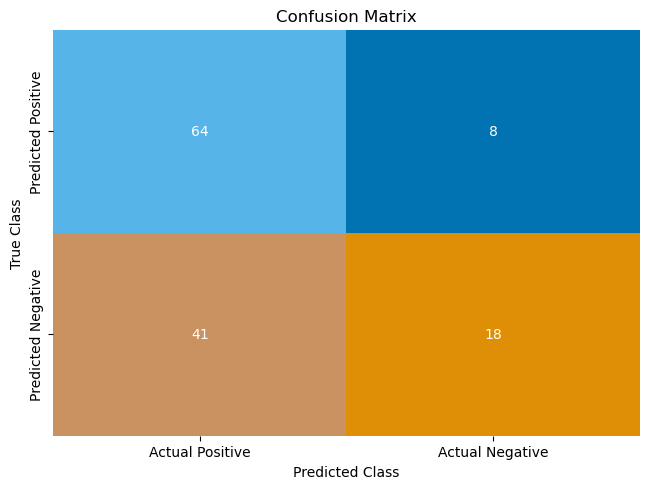

In [50]:
# Cunfusion matrix
test_labels = test.iloc[:,0]

matrix = confusion_matrix(test_labels, target_predicted['binary'])
df_confusion = pd.DataFrame(matrix, index=['Predicted Positive','Predicted Negative'],columns=['Actual Positive','Actual Negative'])

colormap = sns.color_palette("colorblind")
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [52]:
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted['binary']).ravel()


In [54]:
# Sensitivity: measures the proportion of the actual positives that are correctly identified
# TODO decide if the sensitivity is good enough
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of predicting survivors as survivors")

Sensitivity or TPR: 30.508474576271187%
There is a 30.508474576271187% chance of predicting survivors as survivors


In [58]:
# Specificity: proportion of actual negatives correctly identified
# TODO decide if the specificity is good enough
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of predicting non-survivors as non-survivors")

Specificity or TNR: 88.88888888888889%
There is a 88.88888888888889% chance of predicting non-survivors as non-survivors


In [57]:
# Positive predictive value: the probability that a positive result is actually positive
# TODO
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You will survive, and the probablity that is correct is {Precision}%")

Precision: 69.23076923076923%
You will survive, and the probablity that is correct is 69.23076923076923%


In [60]:
# Negative predictive value: probability negative result is actually negative
# TODO
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Negative Predictive Value: 60.952380952380956%
You don't have an abnormality, but there is a 60.952380952380956% chance that is incorrect


In [61]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 11.11111111111111%
There is a 11.11111111111111% chance that this positive result is incorrect.


In [62]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 69.49152542372882%
There is a 69.49152542372882% chance that this negative result is incorrect.


In [63]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 30.76923076923077%
You have an abnormality, but there is a 30.76923076923077% chance this is incorrect.


In [64]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 62.59541984732825%


In [65]:
# TODO maybe not leave this here put use if for comparison
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 30.508474576271187%
Specificity or TNR: 88.88888888888889%
Precision: 69.23076923076923%
Negative Predictive Value: 60.952380952380956%
False Positive Rate: 11.11111111111111%
False Negative Rate: 69.49152542372882%
False Discovery Rate: 30.76923076923077%
Accuracy: 62.59541984732825%


#### AUC-ROC Curve

In [73]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted['class']) )

Validation AUC 0.7176318267419962


In [76]:
thresholds

array([       inf, 0.93828672, 0.90257764, 0.89230049, 0.89087176,
       0.86267769, 0.84015167, 0.82386434, 0.81468046, 0.78162229,
       0.7577548 , 0.73040915, 0.72846186, 0.68059438, 0.66790676,
       0.48600456, 0.47315636, 0.4673638 , 0.44736212, 0.44223645,
       0.41194341, 0.4051536 , 0.39410385, 0.38053873, 0.37681022,
       0.35415763, 0.35116598, 0.3340587 , 0.31266785, 0.31121668,
       0.30241561, 0.2923598 , 0.25741616, 0.20865756, 0.20531213,
       0.20076187, 0.19968086, 0.19549988, 0.19541942, 0.19536626,
       0.17711653, 0.1685212 , 0.16137497, 0.14835666, 0.14672828,
       0.12277763, 0.11443017, 0.11062032, 0.10767998, 0.09150109,
       0.09090448, 0.06566834, 0.0623375 , 0.04636068, 0.03131077,
       0.01922547, 0.0164527 , 0.00926938])

Figure(640x480)


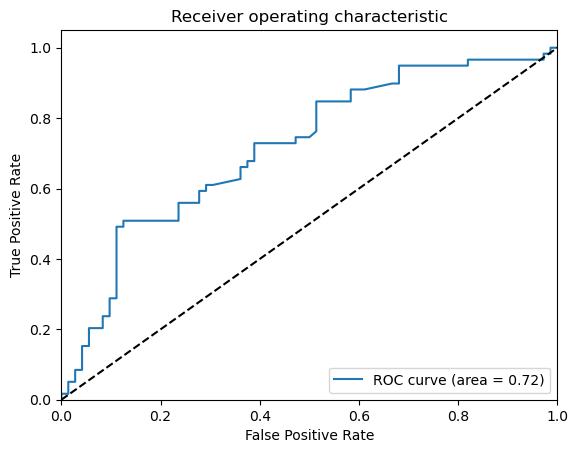

<Figure size 640x480 with 0 Axes>

In [77]:
# TODO Update the previous code to use *target_predicted_binary* instead of *target_predicted*. How does that change the graph? Which is the most useful?
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted['class'])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

print(plt.figure())

## Tuning the Model

In [ ]:
%%time
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have limit set for these instances
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.Session())


xgb.set_hyperparameters(eval_metric='error@.40',
                        objective='binary:logistic',
                        num_round=42)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }

objective_metric_name = 'validation:error'
objective_type = 'Minimize'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-231026-1224


.......................................................................................................

In [ ]:
# Make sure the job finished succesfully
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

In [ ]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(20)

In [ ]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

In [ ]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})

In [ ]:
%%time
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_algo_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)


xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
best_target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

best_target_predicted_binary = best_target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]

In [ ]:
plot_confusion_matrix(test_labels, best_target_predicted_binary)

In [ ]:
plot_roc(test_labels, best_target_predicted_binary)